In [1]:
import keras
import tensorflow as tf
import keras.layers as layers
import keras.activations as activations
import numpy as np

import pylab as pl
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal 
from scipy.io import wavfile

import sounddevice as sd

2022-04-21 10:05:50.631747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 10:05:50.631775: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Mise en place des données tests

/tmp/ipykernel_3740/2850441478.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, sls = wavfile.read('Sls.wav')


172.8


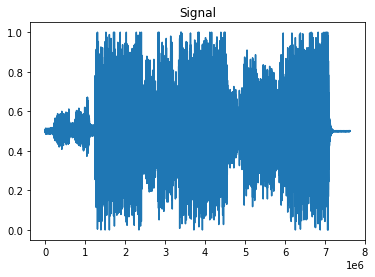

In [2]:
rate, sls = wavfile.read('Sls.wav')
sls = sls/np.max(sls)

N = len(sls)
print(N/rate)

time = np.arange(N)/rate

plt.plot(sls)
plt.title('Signal')
plt.show()

#sd.play(sls/np.max(sls),rate)

ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred


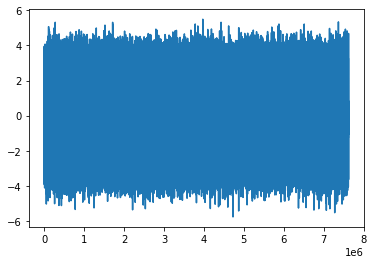

In [3]:
Ns = N
sigma_carre = 1.2

#compute gaussian signal
Samples = np.power(1.2,0.5)*np.random.randn(Ns)
abs = np.arange(Ns)
pl.plot(abs,Samples)
pl.show()

ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred


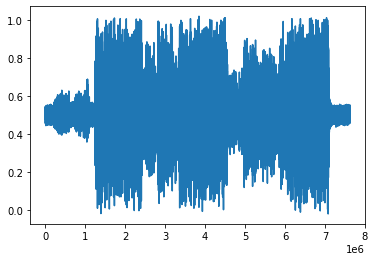

In [4]:
slsn = sls + Samples/90

pl.plot(slsn)

pl.show()

#sd.play(slsn[3200000:3200000+3200000]/np.max(sls),rate)

In [5]:
def make_extrait(x,fs):
    data = np.zeros((1,fs*2))
    i=0
    data = [x[i:i+fs*2]]
    i+=fs
    while(i+fs*2<len(x)):

        data = np.concatenate((data,[x[i:i+fs*2]]),0)
        i += fs
    
    return data






In [109]:
print(np.shape(sls))

ex_sls = make_extrait(sls,rate)
ex_slsn = make_extrait(slsn,rate)

print(np.shape(ex_sls))
print(np.shape(ex_slsn)) 

stft_c = tf.signal.stft(ex_sls[0],frame_length=512,frame_step=128,window_fn=tf.signal.hann_window)

stft_n = tf.signal.stft(ex_slsn[0],frame_length=512,frame_step=128,window_fn=tf.signal.hann_window)

for i in range(1,np.shape(ex_sls)[0]):
    a = tf.signal.stft(ex_sls[i],frame_length=512,frame_step=128,window_fn=tf.signal.hann_window)
    b = tf.signal.stft(ex_slsn[i],frame_length=512,frame_step=128,window_fn=tf.signal.hann_window)
    

    stft_c = np.concatenate((stft_c,a),axis=0)
    stft_n = np.concatenate((stft_n,b),axis=0)


print(np.shape(stft_c))
print(np.shape(stft_n)) 






(7620480,)
(171, 88200)
(171, 88200)
(117306, 257)
(117306, 257)


In [7]:
print(np.shape(ex_sls))

A = tf.signal.stft(ex_sls[0],frame_length=512,frame_step=128,window_fn=tf.signal.hann_window)

print(np.shape(A))


(171, 88200)
(686, 257)


2022-04-21 10:07:06.143951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 10:07:06.143993: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 10:07:06.144027: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sparekh-Precision-T3610): /proc/driver/nvidia/version does not exist


Nous avons nos deux signaux de base, l'un bruité slsn, et l'autre propre sls.

# 2. Écriture des loss function

In [8]:
a = tf.constant([1,2])
b = tf.constant([3,2])

tf.tensordot(a,b,1).numpy()

7

In [8]:
def L_wav(y_true,y_pred):

    return -tf.divide(tf.tensordot(y_pred,y_true,1),tf.multiply(tf.norm(y_pred),tf.norm(y_true)))

def L_spec(y_true,y_pred):

    return tf.pow(tf.norm(tf.pow(tf.norm(y_true),0.3)-tf.pow(tf.norm(y_pred),0.3)),2)


# 3. Depthwise-separable convolution

In [9]:
class DepthwiseSeparableConv1d(tf.keras.Model):
    def __init__(self, in_channels, out_channels, kernel_size, stride):


        super().__init__()

        shape = ([None, in_channels])
        self.kernel = kernel_size
      
        self.conv1d_1 = layers.Conv1D(out_channels, kernel_size, input_shape =(None, in_channels), padding='same' ,groups = in_channels, strides = stride)
        
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.relu1 = layers.Activation(activations.relu)

        self.conv1d_2 = tf.keras.layers.Conv1D(out_channels , 1)

        self.norm2 = tf.keras.layers.BatchNormalization()
        self.relu2 = layers.Activation(activations.relu)


    def call (self, x):

        x = self.conv1d_1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        print(np.shape(x))

        #pad = np.zeros((np.shape(x)[0],self.kernel//2,np.shape(x)[2]))
        #pad_x = np.concatenate((pad,x.numpy(),pad),axis=1)
        y = self.conv1d_2(x)
        y = self.norm2(y)
        y = self.relu2(y)

        return y



In [10]:
class DepthwiseSeparableConv1d(tf.keras.Model):
    def __init__(self, in_channels, out_channels, kernel_size, stride):


        super().__init__()

        shape = ([None, in_channels])
 
        self.conv1d_ptwise = layers.Conv1D(in_channels,1)

        self.norm1 = tf.keras.layers.BatchNormalization()
        self.relu1 = layers.Activation(activations.relu)

        self.conv1d_dpwise = layers.DepthwiseConv1D(kernel_size,strides=stride,padding = 'same',depth_multiplier=int(out_channels//in_channels),activation=activations.relu)

        self.norm2 = tf.keras.layers.BatchNormalization()
        self.relu2 = layers.Activation(activations.relu)


    def call (self, x):
        #print('dp',np.shape(x))
        x = self.conv1d_ptwise(x)

        x = self.norm1(x)
        x = self.relu1(x)

        #print('dp2',np.shape(x))

        y = self.conv1d_dpwise(x)
       # print('dp3',np.shape(y))

        y = self.norm2(y)
        y = self.relu2(y)

        return y


In [11]:
class FirstBlock_DSConv1d(tf.keras.Model):
    def __init__(self, in_channels, out_channels, kernel_size, stride):


        super().__init__()

        shape = ([None, in_channels])
 
        

        self.conv1d = layers.Conv1D(out_channels,kernel_size,strides=stride,padding = 'same',)

        self.norm = tf.keras.layers.BatchNormalization()
        self.relu = layers.Activation(activations.relu)


    def call (self, x):
        #print('dp',np.shape(x))
        
        y = self.conv1d(x)
        #print('dp3',np.shape(y))

        y = self.norm(y)
        y = self.relu(y)

        return y

In [102]:
model = DepthwiseSeparableConv1d(1,1,5,1)

x = tf.math.abs(tf.constant([stft_n]))
y = tf.math.abs(tf.constant([stft_c]))
print(np.shape(x))
x=tf.transpose(x, perm=[2,1,0])
y=tf.transpose(y, perm=[2,1,0])
print(np.shape(x))

model.compile(loss=L_spec,optimizer='adam')
model.fit(x,y, verbose=2, epochs=1000,batch_size=1000,shuffle=True)

(1, 257, 39501)
(39501, 257, 1)
Epoch 1/1000
dp (None, 257, 1)
dp2 (None, 257, 1)
dp3 (None, 257, 1)
dp (None, 257, 1)
dp2 (None, 257, 1)
dp3 (None, 257, 1)


KeyboardInterrupt: 

In [ ]:
#STFT des signaux et phase
t, f, a = scipy.signal.stft(slsn,rate, 'hann',512,128)
t, f, b = scipy.signal.stft(sls,rate, 'hann',512,128)
phase = np.angle(b)

#mise en forme pour rentrer dans le module
#a est bruité
at = tf.math.abs(tf.constant([a]))
at = tf.transpose(at, perm=[2,1,0])

#b est clean
bt = tf.math.abs(tf.constant([b]))
bt = tf.transpose(bt, perm=[2,1,0])

print(np.shape(at))
print(np.shape(phase))

m = model(at)
ad = tf.transpose(m, perm=[2,1,0])
ar = ad[0] * np.exp(phase*1j)
print(np.shape(ar))



(19846, 257, 1)
(257, 19846)
(19846, 257, 1)
(19846, 257, 1)
(257, 19846)


/Users/thibautvacek/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:6577: ComplexWarning: Casting complex values to real discards the imaginary part
  _ctx, "Mul", name, x, y)


In [12]:
xrec = sp.signal.istft(ar, rate, 'hann',512,128)

rec = xrec[1]
pl.plot(rec)
pl.show()
#sd.play(rec,rate)

NameError: name 'ar' is not defined

# 3. Modèle Encoder qu'on fait évoluer

In [98]:
class Encoder_TRU_Net(tf.keras.Model):

    def __init__(self):


        super().__init__()

        



        self.cnn_1d_block1 = FirstBlock_DSConv1d(1,64,5,2)
        self.cnn_1d_block2 = DepthwiseSeparableConv1d(64,128,3,1)
        self.cnn_1d_block3 = DepthwiseSeparableConv1d(128,128,5,2)
        self.cnn_1d_block4 = DepthwiseSeparableConv1d(128,128,3,1)
        self.cnn_1d_block5 = DepthwiseSeparableConv1d(128,128,5,2)
        self.cnn_1d_block6 = DepthwiseSeparableConv1d(128,128,3,2)
        
        self.faux_layer = layers.Conv1D(257,17)

        self.norm = tf.keras.layers.BatchNormalization()


    def call (self, x):

        p = self.norm(x)
        
        p = tf.signal.stft(p,frame_length=512,frame_step=128,window_fn=tf.signal.hann_window)
        sh = np.shape(p)
        print(np.shape(p))
        #inp = tf.slice(p,[0,0,0],[sh[0],sh[1],sh[2]-1])
        inp = p
        phase = tf.math.angle(inp)

      
        
        inp = tf.expand_dims(tf.abs(inp),axis=3)
        #x = tf.abs(x[:,:-1])
        #À REGARDER DE PLUS PRES LE STFT
        #x = tf.transpose(x, perm=[0,2,3,1])
        print(np.shape(inp))
        out = tf.constant([])

        for i in range(len(inp)):
          
            x = inp[i]
            x = self.cnn_1d_block1(x)
           # print(np.shape(x))
            x = self.cnn_1d_block2(x)
            #print(np.shape(x))
            x = self.cnn_1d_block3(x)
            #print(np.shape(x))
            x = self.cnn_1d_block4(x)
            #print(np.shape(x))
            x = self.cnn_1d_block5(x)
            #print(np.shape(x))
            x = self.cnn_1d_block6(x)
            print(np.shape(x))
            x = self.faux_layer(x)
            print(np.shape(x))
            x = tf.transpose(x,[1,0,2])
            
            if i==0:
                out=x
            else : 
                out = tf.concat([out,x],0)

            
        print(np.shape(out))
        m = tf.cast(out, tf.complex128)
        t = tf.cast(phase, tf.complex128)
        p = tf.math.exp(tf.multiply(tf.constant(1j),t))
        y = tf.multiply(m,p)
        print(np.shape(y))
        y = tf.signal.inverse_stft(y,512,128,window_fn=tf.signal.hann_window)
        return y

## Tentative avec stft dans encoder

In [95]:
class Encoder_TRU_Net(tf.keras.Model):

    def __init__(self):


        super().__init__()

        



        self.cnn_1d_block1 = FirstBlock_DSConv1d(1,64,5,2)
        self.cnn_1d_block2 = DepthwiseSeparableConv1d(64,128,3,1)
        self.cnn_1d_block3 = DepthwiseSeparableConv1d(128,128,5,2)
        self.cnn_1d_block4 = DepthwiseSeparableConv1d(128,128,3,1)
        self.cnn_1d_block5 = DepthwiseSeparableConv1d(128,128,5,2)
        self.cnn_1d_block6 = DepthwiseSeparableConv1d(128,128,3,2)
        
        self.faux_layer = layers.Conv1D(257,17)

        self.norm = tf.keras.layers.BatchNormalization()


    def call (self, x):

        p = self.norm(x)
        
        p = tf.signal.stft(p,frame_length=512,frame_step=128,window_fn=tf.signal.hann_window)
        sh = np.shape(p)
        print(np.shape(p))
        #inp = tf.slice(p,[0,0,0],[sh[0],sh[1],sh[2]-1])
        inp = p
        phase = tf.math.angle(inp)

      
        
        inp = tf.expand_dims(tf.abs(inp),axis=-1)
        #x = tf.abs(x[:,:-1])
        #À REGARDER DE PLUS PRES LE STFT
        #x = tf.transpose(x, perm=[0,2,3,1])
        print(np.shape(inp))
        x = inp

        
        x = self.cnn_1d_block1(x)
        # print(np.shape(x))
        x = self.cnn_1d_block2(x)
        #print(np.shape(x))
        x = self.cnn_1d_block3(x)
        #print(np.shape(x))
        x = self.cnn_1d_block4(x)
        #print(np.shape(x))
        x = self.cnn_1d_block5(x)
        #print(np.shape(x))
        x = self.cnn_1d_block6(x)
        print(np.shape(x))
        x = self.faux_layer(x)
        print(np.shape(x))
        x = tf.transpose(x,[1,0,2])
        
        out = x[0]

            
        print(np.shape(out))
        m = tf.cast(out, tf.complex128)
        t = tf.cast(phase, tf.complex128)
        p = tf.math.exp(tf.multiply(tf.constant(1j),t))
        y = tf.multiply(m,p)
        print(np.shape(y))
        y = tf.signal.inverse_stft(y,512,128,window_fn=tf.signal.hann_window)
        return y

In [96]:
encoder = Encoder_TRU_Net()
print(np.shape(ex_slsn))
y=encoder(ex_slsn[0])
print(np.shape(y))

(171, 88200)
(686, 257)
(686, 257, 1)
(686, 17, 128)
(686, 1, 257)
(686, 257)
(686, 257)
(88192,)


In [97]:

encoder = Encoder_TRU_Net()
encoder.compile(loss=L_wav,optimizer='adam')
encoder.fit(ex_slsn,ex_sls, verbose=2, epochs=100,batch_size=10,shuffle=True)
y = encoder(ex_sls[0])

print(np.shape(y))

Epoch 1/100
(None, 686, 257)
(None, 686, 257, 1)


ValueError: in user code:

    File "/home/mbuisson/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/mbuisson/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mbuisson/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/mbuisson/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/home/mbuisson/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "encoder_tru__net_44" (type Encoder_TRU_Net).
    
    in user code:
    
        File "/tmp/ipykernel_3740/118062852.py", line 47, in call  *
            x = self.cnn_1d_block2(x)
        File "/home/mbuisson/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        ValueError: Exception encountered when calling layer "depthwise_separable_conv1d_220" (type DepthwiseSeparableConv1d).
        
        in user code:
        
            File "/tmp/ipykernel_3740/2421589345.py", line 29, in call  *
                y = self.conv1d_dpwise(x)
            File "/home/mbuisson/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/home/mbuisson/anaconda3/lib/python3.9/site-packages/keras/layers/convolutional.py", line 2406, in build
                raise ValueError('Inputs to `DepthwiseConv` should have '
        
            ValueError: Inputs to `DepthwiseConv` should have rank 3. Received input_shape=(None, 686, 129, 64).
        
        
        Call arguments received:
          • x=tf.Tensor(shape=(None, 686, 129, 64), dtype=float32)
    
    
    Call arguments received:
      • x=tf.Tensor(shape=(None, 88200), dtype=float32)


## Tentative avec stft hors encoder

In [112]:
class Encoder_TRU_Net(tf.keras.Model):

    def __init__(self):


        super().__init__()

        



        self.cnn_1d_block1 = FirstBlock_DSConv1d(1,64,5,2)
        self.cnn_1d_block2 = DepthwiseSeparableConv1d(64,128,3,1)
        self.cnn_1d_block3 = DepthwiseSeparableConv1d(128,128,5,2)
        self.cnn_1d_block4 = DepthwiseSeparableConv1d(128,128,3,1)
        self.cnn_1d_block5 = DepthwiseSeparableConv1d(128,128,5,2)
        self.cnn_1d_block6 = DepthwiseSeparableConv1d(128,128,3,2)
        
        self.faux_layer = layers.Conv1D(257,17)

        self.norm = tf.keras.layers.BatchNormalization()


    def call (self, x):

        
        x = tf.expand_dims(x,axis=-1)
        
        x = self.cnn_1d_block1(x)
        # print(np.shape(x))
        x = self.cnn_1d_block2(x)
        #print(np.shape(x))
        x = self.cnn_1d_block3(x)
        #print(np.shape(x))
        x = self.cnn_1d_block4(x)
        #print(np.shape(x))
        x = self.cnn_1d_block5(x)
        #print(np.shape(x))
        x = self.cnn_1d_block6(x)
        #print(np.shape(x))
        x = self.faux_layer(x)
        #print(np.shape(x))
        x = tf.transpose(x,[1,0,2])
        
        out = x[0]

            
       # print(np.shape(out))
        
        return out

In [114]:
phase = tf.math.angle(stft_c)

print(np.shape(inp))

x = inp

encoder = Encoder_TRU_Net()
encoder.compile(loss=L_spec,optimizer='adam')
encoder.fit(tf.abs(stft_n),tf.abs(stft_c), verbose=1, epochs=6, batch_size=1000,shuffle=True)

'''
m = tf.cast(out, tf.complex128)
t = tf.cast(phase, tf.complex128)
p = tf.math.exp(tf.multiply(tf.constant(1j),t))
y = tf.multiply(m,p)
print(np.shape(y))
y = tf.signal.inverse_stft(y,512,128,window_fn=tf.signal.hann_window)
'''

(171, 686, 257)
Epoch 1/6
118/118 [==============================] - 104s 854ms/step - loss: 2.1094
Epoch 2/6
118/118 [==============================] - 101s 857ms/step - loss: 7.7386e-05
Epoch 3/6
118/118 [==============================] - 101s 854ms/step - loss: 8.5858e-05
Epoch 4/6
118/118 [==============================] - 100s 844ms/step - loss: 1.1472e-04
Epoch 5/6
118/118 [==============================] - 100s 846ms/step - loss: 8.1276e-05
Epoch 6/6
118/118 [==============================] - 104s 879ms/step - loss: 1.4612e-04


'\nm = tf.cast(out, tf.complex128)\nt = tf.cast(phase, tf.complex128)\np = tf.math.exp(tf.multiply(tf.constant(1j),t))\ny = tf.multiply(m,p)\nprint(np.shape(y))\ny = tf.signal.inverse_stft(y,512,128,window_fn=tf.signal.hann_window)\n'

In [128]:
stft_n_t = tf.signal.stft(slsn,frame_length=512,frame_step=128,window_fn=tf.signal.hann_window)
phase = tf.math.angle(tf.signal.stft(sls,frame_length=512,frame_step=128,window_fn=tf.signal.hann_window))
out = encoder(tf.abs(stft_n_t))

m = tf.cast(out, tf.complex128)
t = tf.cast(phase, tf.complex128)
p = tf.math.exp(tf.multiply(tf.constant(1j),t))
y = tf.multiply(m,p)
print(np.shape(y))
#y = tf.signal.inverse_stft(y,512,128,window_fn=tf.signal.hann_window)

(59532, 257)


In [124]:
np.shape(Zxx)

(257, 19846)

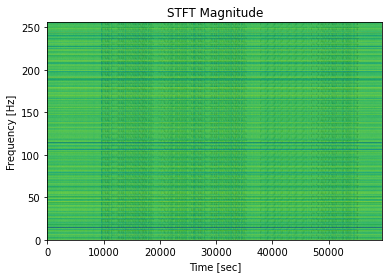

In [129]:
from scipy import signal

import matplotlib.pyplot as plt
f = np.arange(257)
t = np.arange(59532)



plt.pcolormesh(t, f, np.transpose(np.power(np.abs(y),0.1)), shading='gouraud')

plt.title('STFT Magnitude')

plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')
plt.show()


# 4. Construction du GRU layer

In [131]:
class GRU_Block(tf.keras.Model):

    def __init__(self,out_channels):


        super().__init__()

        gru = layers.GRU(64)

        self.gru_layer = layers.Bidirectional(gru)
        
        self.norm = tf.keras.layers.BatchNormalization()
        self.relu = layers.Activation(activations.relu)

        self.conv1d_ptwise = layers.Conv1D(out_channels,1)
    

  


    def call (self, x):

        
        output = self.gru_layer(x)
        #output = output.transpose(1,2)
        
        output = self.conv1d_ptwise(output)
        output = self.norm(self.relu(output))

        return output